# Long-Short Strategy, Part 6: Backtesting with Zipline

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb) : we predict returns for our out-of-sample period 2017.
6. `backtesting_with_zipline` (this noteboook): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

## Imports & Settings

In [874]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pandas_datareader.data as web

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap


In [875]:
N_LONGS = 5

## Load Data

### ML Predictions

In [876]:
DATA_STORE = './data/assets.h5'
with pd.HDFStore(DATA_STORE) as store:
    prices = store['merval/prices'].sort_index()['close'].loc[pd.IndexSlice['2000':'2024']]
prices.index.names = ['date', 'symbol']
prices

date        symbol  
2000-01-03  BBAR.BA         7.614178
            BHIP.BA         1.385000
            BMA.BA          1.297694
            BOLT.BA         0.017411
            CAPX.BA         1.393596
                            ...     
2023-12-29  TGSU2.BA     2956.149902
            TRAN.BA      1210.000000
            TXAR.BA       849.000000
            VALO.BA       225.250000
            YPFD.BA     16688.199219
Name: close, Length: 299201, dtype: float64

In [877]:
predictions = pd.concat([pd.read_hdf('data/predictions.h5', 'lgb/train/01'), pd.read_hdf('data/predictions.h5', 'lgb/test/01').drop('y_test', axis=1)])
predictions = (predictions.loc[~predictions.index.duplicated()]
				.iloc[:, :10]
				.mean(1)
				.sort_index()
				.dropna()
				.to_frame('prediction'))
tickers = predictions.index.get_level_values('symbol').unique().tolist()

In [878]:
predictions = predictions.join(prices)

In [879]:
predictions

prediction        close
symbol  date                               
ALUA.BA 2020-12-03    0.009860    52.200001
        2020-12-04    0.014928    52.200001
        2020-12-09    0.008148    48.950001
        2020-12-10    0.018542    50.099998
        2020-12-11    0.027393    49.450001
...                        ...          ...
YPFD.BA 2022-12-26   -0.006042  3084.949951
        2022-12-27   -0.009006  3003.800049
        2022-12-28   -0.003205  3130.000000
        2022-12-29   -0.012606  3111.500000
        2022-12-30   -0.009665  3168.449951

[31109 rows x 2 columns]

## Backtesting

In [880]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = predictions

def backtest(df, initial_capital=1):
	portfolio_value = []
	open_positions = dict()
	positions = []
	value = initial_capital

	dates = df.index.levels[1]
	for date in dates:
		daily_df = df.xs(date, level='date')

		# use open open_positions to compute total value
		if len(open_positions) > 0:
			value = 0
			for (ticker, alloc) in open_positions.items():
				if ticker == 'cash':
					value += alloc
				else:
					price = daily_df.loc[ticker, 'close']
					value += price * alloc
		portfolio_value.append(value)

		# select next 5 best predictions
		top_predictions = daily_df[daily_df['prediction'] > 0].nlargest(N_LONGS, 'prediction')

		open_positions = dict()

		if len(top_predictions) == 0:
			open_positions['cash'] = value
		else:
			# update open open_positions
			allocation = value / len(top_predictions)
			for ticker in top_predictions.index:
				price = daily_df.loc[ticker, 'close']
				open_positions[ticker] = allocation / price
			
		positions.append(open_positions)

	return portfolio_value, positions

portfolio_value, positions = backtest(df)

portfolio_df = pd.DataFrame({
    'date': df.index.levels[1],
    'portfolio_value': portfolio_value,
	'positions': positions
})
portfolio_df

,date,portfolio_value,positions
0,2020-12-03,1.000000,"{'IRSA.BA': 0.0026355708768131215, 'OEST.BA': ..."
1,2020-12-04,0.997674,"{'LONG.BA': 0.03320045762144735, 'CRES.BA': 0...."
2,2020-12-09,0.964029,"{'GRIM.BA': 0.007140955229340305, 'IRSA.BA': 0..."
3,2020-12-10,0.974099,"{'LEDE.BA': 0.006504835376933618, 'ROSE.BA': 0..."
4,2020-12-11,0.981612,"{'LEDE.BA': 0.006599074247481262, 'ALUA.BA': 0..."
...,...,...,...
741,2023-12-21,1430.505016,"{'ALUA.BA': 0.30147629417677835, 'BBAR.BA': 0...."
742,2023-12-22,1445.297018,"{'ALUA.BA': 0.30702007825266275, 'COME.BA': 3...."
743,2023-12-26,1402.617014,"{'DYCA.BA': 0.7846808470743822, 'MIRG.BA': 0.0..."
744,2023-12-27,1365.862762,"{'MIRG.BA': 0.026747532794179466, 'ALUA.BA': 0..."


In [881]:
df_expanded = portfolio_df['positions'].apply(pd.Series).fillna(0)
positions_df = pd.concat([portfolio_df['date'], df_expanded], axis=1)
positions_df['date'] = pd.to_datetime(positions_df['date'])
positions_df = positions_df.set_index(['date']).tz_localize('UTC')

Graficar resultados

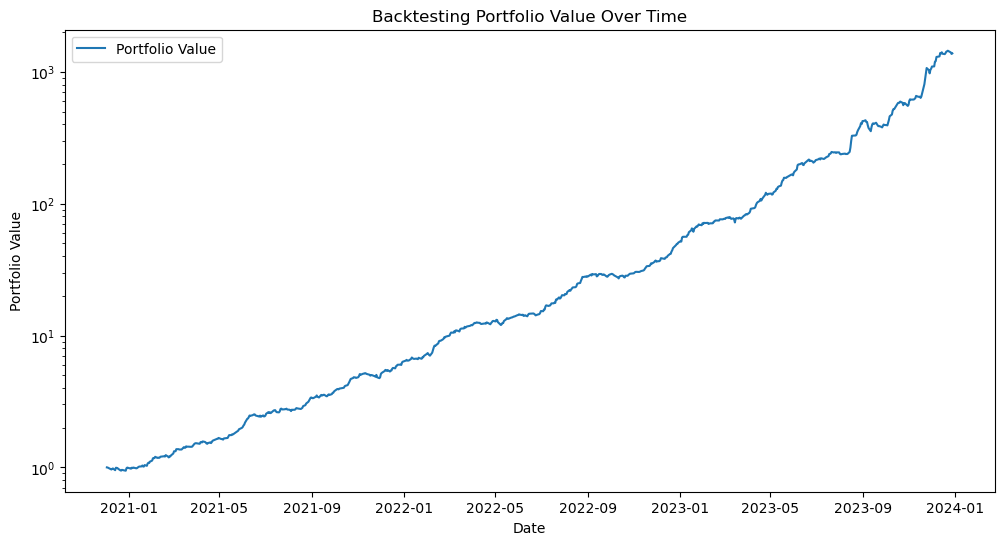

In [882]:
# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df['date'], portfolio_df['portfolio_value'], label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.yscale('log')
plt.title('Backtesting Portfolio Value Over Time')
plt.legend()
plt.show()


In [883]:
sp_merval = pd.read_csv('./data/merval.csv')
sp_merval = sp_merval[['Date','Adj Close']].rename(columns={'Date':'date', 'Adj Close':'close'}).set_index(['date'])['close']

In [884]:
portfolio_df = portfolio_df.set_index(['date'])

In [885]:
sp_merval.reindex(portfolio_df.index)

date
2020-12-03   NaN
2020-12-04   NaN
2020-12-09   NaN
2020-12-10   NaN
2020-12-11   NaN
              ..
2023-12-21   NaN
2023-12-22   NaN
2023-12-26   NaN
2023-12-27   NaN
2023-12-28   NaN
Name: close, Length: 746, dtype: float64

In [886]:
DATA_STORE = './data/assets.h5'
ohlcv = ['open', 'close', 'low', 'high', 'volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['merval/prices'][ohlcv])


## Generacion de indice del panel lider

In [887]:
import requests
from bs4 import BeautifulSoup

# get all components of merval index
url = "https://es.wikipedia.org/wiki/S%26P_Merval"

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

panel_lider_section = soup.find(id="Empresas_que_participan_Panel_Líder")
lider_table = panel_lider_section.find_next("table")

panel_lider = []
for row in lider_table.find_all('tr')[1:]:  # Skip the header row
    cols = row.find_all('td')
    ticker = cols[0].text.strip()
    panel_lider.append(ticker + ".BA")
len(panel_lider)

21

In [888]:
index = predictions.index.levels[0].intersection(panel_lider)


In [889]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = predictions
positions = []

def backtest(df, initial_capital=1):
	portfolio_value = []
	open_positions = dict()
	value = initial_capital

	dates = df.index.levels[1]
	for date in dates:
		daily_df = df.xs(date, level='date')

		# use open open_positions to compute total value
		if len(open_positions) > 0:
			value = 0
			for (ticker, alloc) in open_positions.items():
				price = daily_df.loc[ticker, 'close']
				value += price * alloc
		portfolio_value.append(value)

		# update open open_positions
		open_positions = dict()
		allocation = value / len(index)
		for ticker in index:
			price = daily_df.loc[ticker, 'close']
			open_positions[ticker] = allocation / price
		positions.append(open_positions)

	return portfolio_value

index_value = backtest(df)

index_df = pd.DataFrame({
    'date': df.index.levels[1],
    'MERVAL': index_value,
	'positions': positions
})

KeyError: 'PAMP.BA'

In [ ]:
index_df

,date,MERVAL,positions
0,2020-12-03,1.000000,"{'ALUA.BA': 0.0012771391895074098, 'BBAR.BA': ..."
1,2020-12-04,0.989274,"{'ALUA.BA': 0.0012634407536674418, 'BBAR.BA': ..."
2,2020-12-09,0.951113,"{'ALUA.BA': 0.0012953534021882297, 'BBAR.BA': ..."
3,2020-12-10,0.969626,"{'ALUA.BA': 0.0012902537084830152, 'BBAR.BA': ..."
4,2020-12-11,0.972872,"{'ALUA.BA': 0.0013115904163659448, 'BBAR.BA': ..."
...,...,...,...
741,2023-12-21,17.657864,"{'ALUA.BA': 0.0012404541093236213, 'BBAR.BA': ..."
742,2023-12-22,17.782588,"{'ALUA.BA': 0.0012591671521615844, 'BBAR.BA': ..."
743,2023-12-26,17.212227,"{'ALUA.BA': 0.0012936660677607544, 'BBAR.BA': ..."
744,2023-12-27,16.525203,"{'ALUA.BA': 0.0013115240759081323, 'BBAR.BA': ..."


## Generacion de indice de panel gral

In [ ]:
import requests
from bs4 import BeautifulSoup

# get all components of merval index
url = "https://es.wikipedia.org/wiki/S%26P_Merval"

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

panel_gral_section = soup.find(id="Empresas_panel_general")
general_table = panel_gral_section.find_next("table")

panel_gral = []
for row in general_table.find_all('tr')[1:]:  # Skip the header row
    cols = row.find_all('td')
    ticker = cols[0].text.strip()
    panel_gral.append(ticker + ".BA")
len(panel_gral)

41

In [ ]:
index_lider = predictions.index.levels[0].intersection(panel_gral)
index_lider

Index(['BOLT.BA', 'BPAT.BA', 'CADO.BA', 'CAPX.BA', 'CARC.BA', 'CECO2.BA',
       'CGPA2.BA', 'CTIO.BA', 'DGCU2.BA', 'DOME.BA', 'DYCA.BA', 'FERR.BA',
       'FIPL.BA', 'GARO.BA', 'GBAN.BA', 'GRIM.BA', 'HAVA.BA', 'INTR.BA',
       'INVJ.BA', 'LEDE.BA', 'LONG.BA', 'METR.BA', 'MOLI.BA', 'MORI.BA',
       'OEST.BA', 'PATA.BA', 'POLL.BA', 'ROSE.BA'],
      dtype='object', name='symbol')

In [ ]:
predictions.xs('CARC.BA', level='symbol')

,prediction,close
date,,
2020-12-03,0.011297,2.62
2020-12-04,0.011843,2.63
2020-12-09,0.008373,2.51
2020-12-10,0.013720,2.54
2020-12-11,0.015458,2.54
...,...,...
2023-12-21,0.011030,12.70
2023-12-22,0.009457,13.15
2023-12-26,-0.002215,13.70


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = predictions
positions = []

def backtest(df, initial_capital=1):
	portfolio_value = []
	open_positions = dict()
	value = initial_capital

	dates = df.index.levels[1]
	for i, date in enumerate(dates):
		daily_df = df.xs(date, level='date')

		# use open open_positions to compute total value
		if len(open_positions) > 0:
			value = 0
			for (ticker, alloc) in open_positions.items():
				try:
					price = daily_df.loc[ticker, 'close']
				except:
					price = df.xs(dates[i-1], level='date').loc[ticker, 'close']
				value += price * alloc
		portfolio_value.append(value)

		# update open open_positions
		open_positions = dict()
		allocation = value / len(index_lider)
		for ticker in index_lider:
			try:
				price = daily_df.loc[ticker, 'close']
			except:
				price = df.xs(dates[i-1], level='date').loc[ticker, 'close']
			open_positions[ticker] = allocation / price
		positions.append(open_positions)

	return portfolio_value

index_value = backtest(df)

index_gral_df = pd.DataFrame({
    'date': df.index.levels[1],
    'MERVAL': index_value,
	'positions': positions
})

In [ ]:
index_gral_df

,date,MERVAL,positions
0,2020-12-03,1.000000,"{'BOLT.BA': 0.007954184306203567, 'BPAT.BA': 0..."
1,2020-12-04,1.001885,"{'BOLT.BA': 0.008077108562664947, 'BPAT.BA': 0..."
2,2020-12-09,0.982917,"{'BOLT.BA': 0.008014648477610253, 'BPAT.BA': 0..."
3,2020-12-10,0.991031,"{'BOLT.BA': 0.00811788151141125, 'BPAT.BA': 0...."
4,2020-12-11,0.991456,"{'BOLT.BA': 0.008121364369289952, 'BPAT.BA': 0..."
...,...,...,...
741,2023-12-21,21.632037,"{'BOLT.BA': 0.03337247331602921, 'BPAT.BA': 0...."
742,2023-12-22,21.640315,"{'BOLT.BA': 0.03412222565231324, 'BPAT.BA': 0...."
743,2023-12-26,21.162325,"{'BOLT.BA': 0.03459026554182236, 'BPAT.BA': 0...."
744,2023-12-27,20.705544,"{'BOLT.BA': 0.03555210231597162, 'BPAT.BA': 0...."


## Dolarizacion de metricas

Obtener cotizacion del dolar BOLSA

In [ ]:
import requests
from datetime import timedelta, datetime

# Función para obtener los tipos de cambio de dolarhoy.com
def get_exchange_rate_history():
    url = "https://api.argentinadatos.com/v1/cotizaciones/dolares"  # Endpoint hipotético, cambia según el correcto
    response = requests.get(url)
    data = response.json()

    # Filtrar los datos para incluir solo aquellos con casa: "blue"
    exchange_rates = [
        {'date': item['fecha'], 'exchange_rate': item['venta']}
        for item in data
        if item['casa'] == 'bolsa'
    ]

    # Convertir a DataFrame
    df_exchange_rates = pd.DataFrame(exchange_rates)
    
    # Convertir la columna 'date' a datetime
    df_exchange_rates['date'] = pd.to_datetime(df_exchange_rates['date'], format='%Y-%m-%d')
    
    return df_exchange_rates

exchange_rates = get_exchange_rate_history()

In [ ]:
exchange_rates = exchange_rates.set_index('date')

In [ ]:
exchange_rates = exchange_rates.reindex(portfolio_df.index)
exchange_rates

,exchange_rate
date,
2020-12-03,139.74
2020-12-04,142.05
2020-12-09,139.49
2020-12-10,138.22
2020-12-11,138.22
...,...
2023-12-21,971.13
2023-12-22,956.13
2023-12-26,945.02


In [ ]:
a = portfolio_df['portfolio_value'] / exchange_rates['exchange_rate']
portfolio_df['portfolio_value'] = a / a[0]
portfolio_df

,portfolio_value,positions
date,,
2020-12-03,1.000000,"{'IRSA.BA': 0.0026355708768131215, 'OEST.BA': ..."
2020-12-04,0.981450,"{'LONG.BA': 0.03320045762144735, 'CRES.BA': 0...."
2020-12-09,0.965757,"{'GRIM.BA': 0.007140955229340305, 'IRSA.BA': 0..."
2020-12-10,0.984811,"{'LEDE.BA': 0.006504835376933618, 'ROSE.BA': 0..."
2020-12-11,0.992407,"{'LEDE.BA': 0.006599074247481262, 'ALUA.BA': 0..."
...,...,...
2023-12-21,133.411639,"{'ALUA.BA': 0.1953953102389225, 'CAPX.BA': 0.0..."
2023-12-22,137.615050,"{'MOLI.BA': 0.07075638945077901, 'ALUA.BA': 0...."
2023-12-26,136.428185,"{'CAPX.BA': 0.03592769393740762, 'ALUA.BA': 0...."


## PyFolio Analysis

In [ ]:
returns = portfolio_df['portfolio_value'].pct_change().tz_localize('UTC')

In [ ]:
sp_merval = pd.read_csv('./data/merval.csv')
sp_merval = sp_merval[['Date','Adj Close']].rename(columns={'Date':'date', 'Adj Close':'MERVAL'})
sp_merval['date'] = pd.to_datetime(sp_merval['date'])
# LO DE ARRIBA ES PARA CARGAR EL INDICE MERVAL, LO DE ABAJO PARA USAR EL INDICE TRUCHO (rinden casi igual)
# sp_merval = index_df
# sp_merval = index_gral_df

In [ ]:
sp_merval = sp_merval.set_index(['date'])
sp_merval = sp_merval.reindex(portfolio_df['portfolio_value'].index)

# COMENTAR ESTA LINEA PARA EXPRESAR EN PESOS
sp_merval['MERVAL'] = sp_merval['MERVAL'] / exchange_rates['exchange_rate']


KeyError: "None of ['date'] are in the columns"

In [ ]:
benchmark = sp_merval['MERVAL'].pct_change().tz_localize('UTC')
benchmark = benchmark.reindex(returns.index)

In [ ]:
import yfinance as yf

start_date = '2020-01-01'
end_date = '2024-01-01'
sp500_values = yf.download('SPY', start=start_date, end=end_date)['Adj Close']
sp500_values

[*********************100%%**********************]  1 of 1 completed


Date
2020-01-02    303.135559
2020-01-03    300.840179
2020-01-06    301.987854
2020-01-07    301.138733
2020-01-08    302.743683
                 ...    
2023-12-22    470.664490
2023-12-26    472.651886
2023-12-27    473.506500
2023-12-28    473.685333
2023-12-29    472.314026
Name: Adj Close, Length: 1006, dtype: float64

In [ ]:
sp500_benchmark = sp500_values.pct_change().tz_localize('UTC').reindex(returns.index)

### Custom Plots

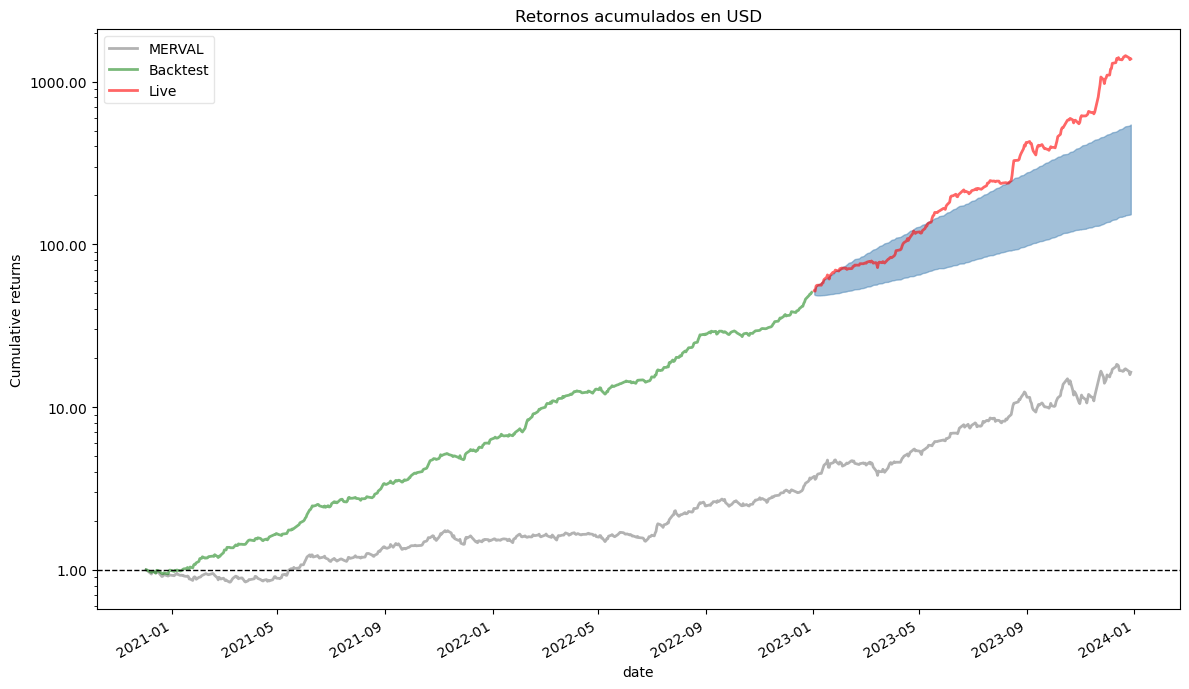

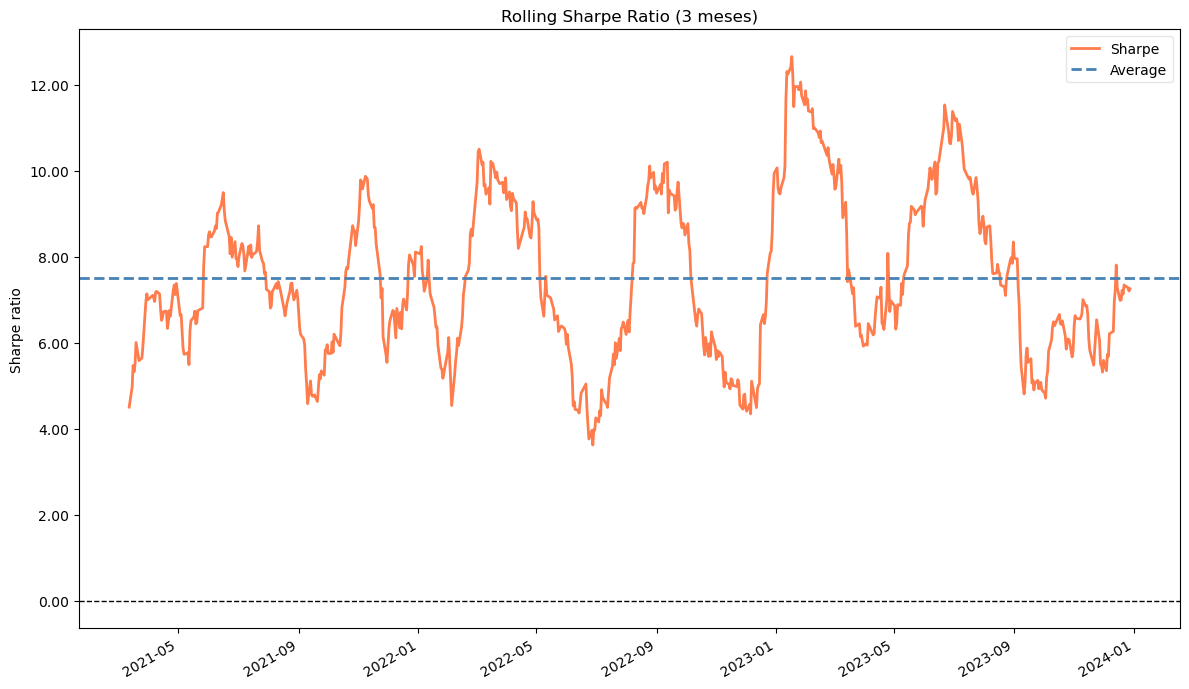

In [ ]:
fig1, ax1 = plt.subplots(figsize=(12, 7))
plot_rolling_returns(
    returns,
    factor_returns=benchmark,
    live_start_date='2023-01-01',
    logy=True,
    cone_std=2,
    legend_loc='best',
    volatility_match=False,
    cone_function=forecast_cone_bootstrap,
    ax=ax1
)
ax1.set_title('Retornos acumulados en USD')
fig1.tight_layout()

fig2, ax2 = plt.subplots(figsize=(12, 7))
plot_rolling_sharpe(returns, ax=ax2, rolling_window=63)
ax2.set_title('Rolling Sharpe Ratio (3 meses)')
fig2.tight_layout()

plt.show()


Compute anualized variation of merval:

In [ ]:
first_row = sp_merval.iloc[0]
last_row = sp_merval.iloc[-1]
increase = (last_row['MERVAL'] / first_row['MERVAL'])
print(f'The MERVAL index grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The MERVAL index grew by x16.392280
Anualized is: %254.026944


In [ ]:
first_row = portfolio_df.iloc[0]
last_row = portfolio_df.iloc[-1]
increase = (last_row['portfolio_value'] / first_row['portfolio_value'])
print(f'The PORTFOLIO grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The PORTFOLIO grew by x1379.692710
Anualized is: %1113.253638


In [ ]:
first_row = sp500_values.iloc[0]
last_row = sp500_values.iloc[-1]
increase = (last_row / first_row)
print(f'The SP500 grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The SP500 grew by x1.558095
Anualized is: %115.930574


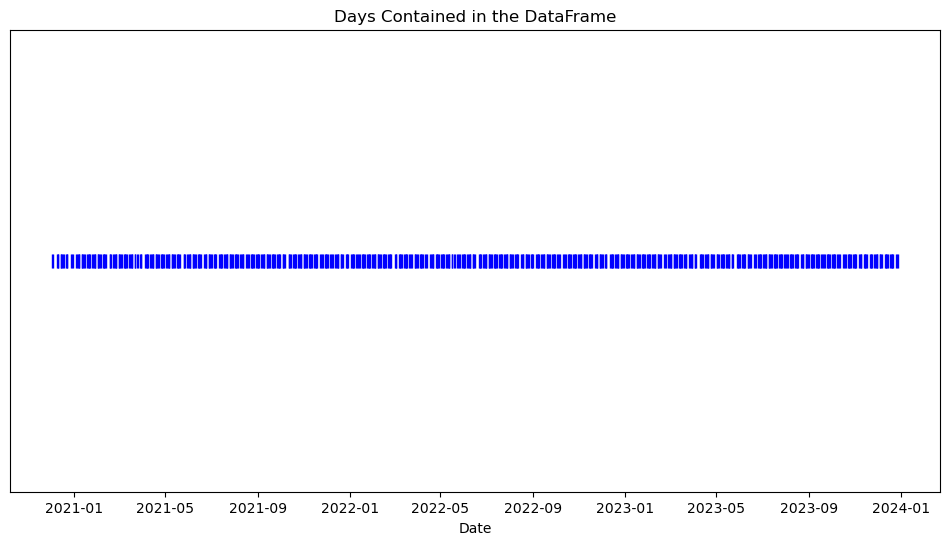

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ejemplo de creación de DataFrame
dates = portfolio_df.index
portfolio_values = portfolio_df['portfolio_value']
df = pd.DataFrame({'portfolio_value': portfolio_values}, index=dates)

# Crear una serie de datos indicando los días contenidos en el DataFrame
days_in_df = df.index

# Graficar los días contenidos en el DataFrame
plt.figure(figsize=(12, 6))
plt.plot(days_in_df, [1]*len(days_in_df), '|', color='blue', markersize=10)  # Use pipe marker to indicate dates
plt.xlabel('Date')
plt.title('Days Contained in the DataFrame')
plt.yticks([])  # Remove y-axis ticks since we only care about the dates
plt.show()


### Tear Sheets

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.40,2023-09-04,2023-09-11,2023-10-05,24
1,8.99,2023-03-08,2023-03-15,2023-03-27,14
2,8.90,2023-11-24,2023-11-28,2023-12-01,6
3,8.69,2022-05-03,2022-05-09,2022-05-16,10
4,8.41,2021-11-10,2021-11-29,2021-12-02,17


/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/pyfolio/plotting.py:1407: UserWarning: FixedFormatter should only be used together with FixedLocator
  )


Stress Events,mean,min,max
Covid,1.00%,-5.61%,23.86%


Top 10 long positions of all time,max
LONG.BA,100.00%
CECO2.BA,100.00%
POLL.BA,100.00%
GARO.BA,100.00%
DOME.BA,100.00%
CARC.BA,100.00%
MOLI.BA,100.00%
CTIO.BA,100.00%
INVJ.BA,96.86%
BOLT.BA,93.90%


Top 10 short positions of all time,max


Top 10 positions of all time,max
LONG.BA,100.00%
CECO2.BA,100.00%
POLL.BA,100.00%
GARO.BA,100.00%
DOME.BA,100.00%
CARC.BA,100.00%
MOLI.BA,100.00%
CTIO.BA,100.00%
INVJ.BA,96.86%
BOLT.BA,93.90%


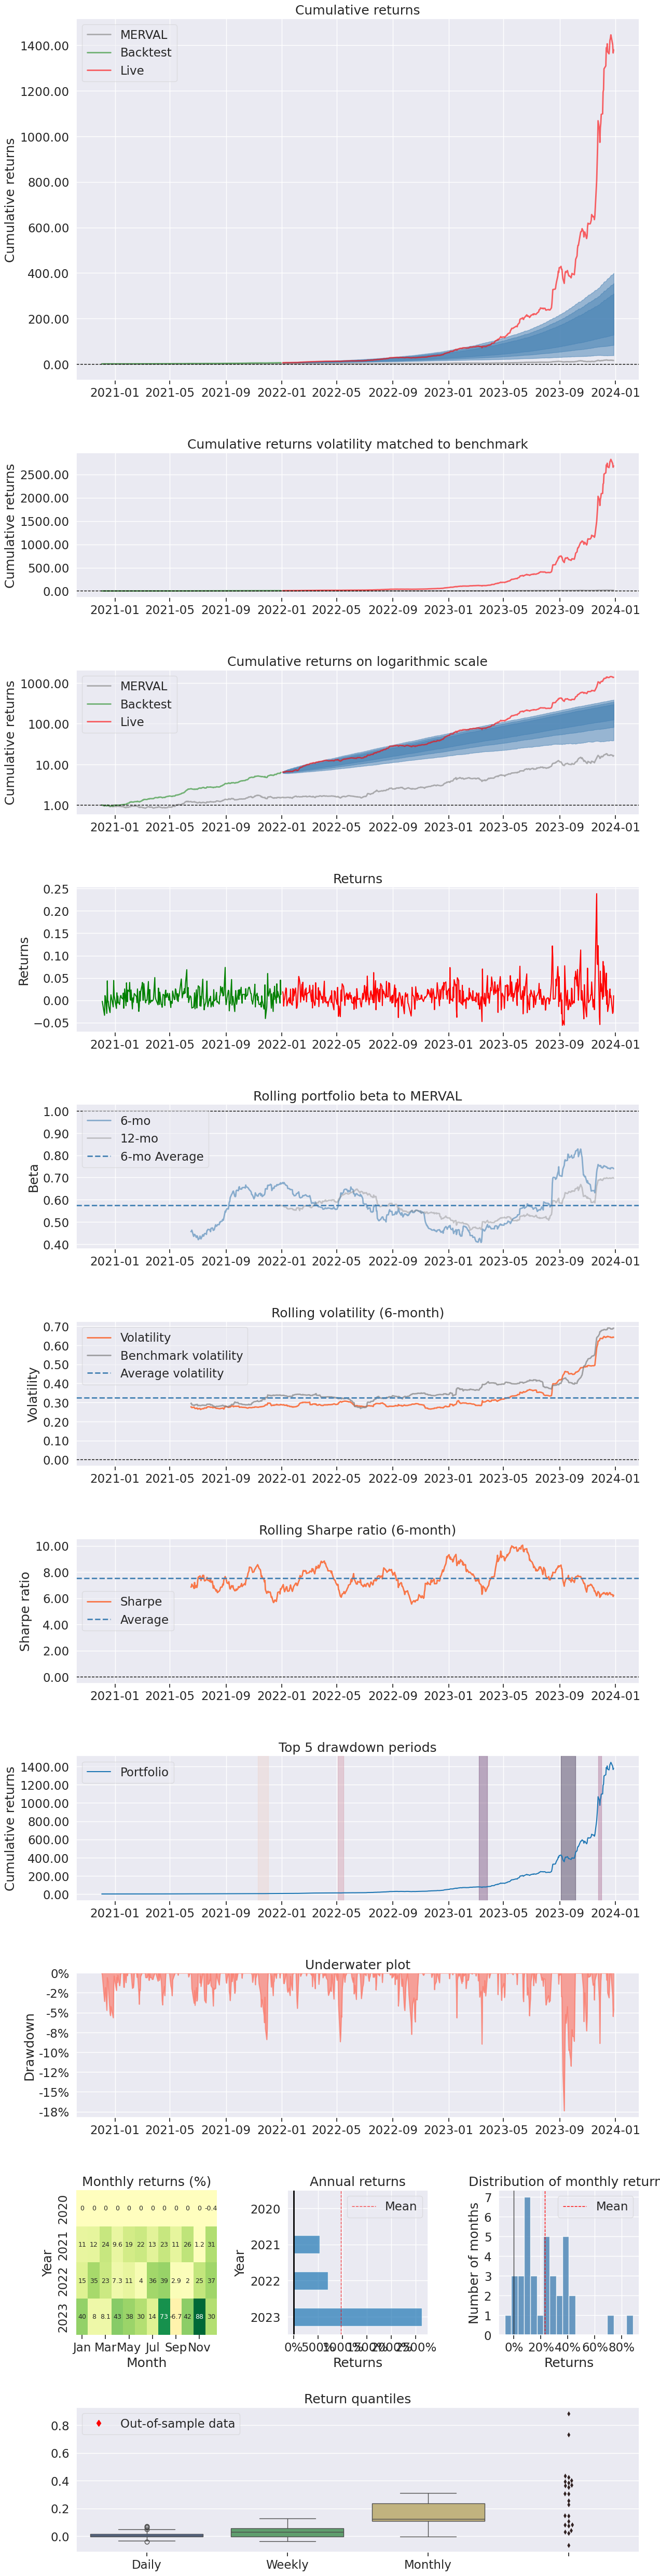

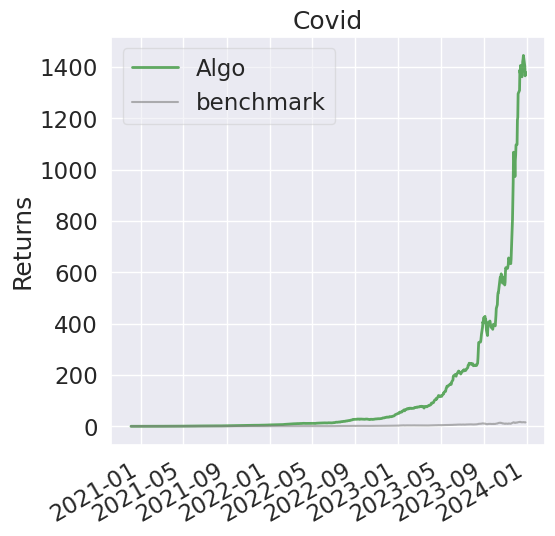

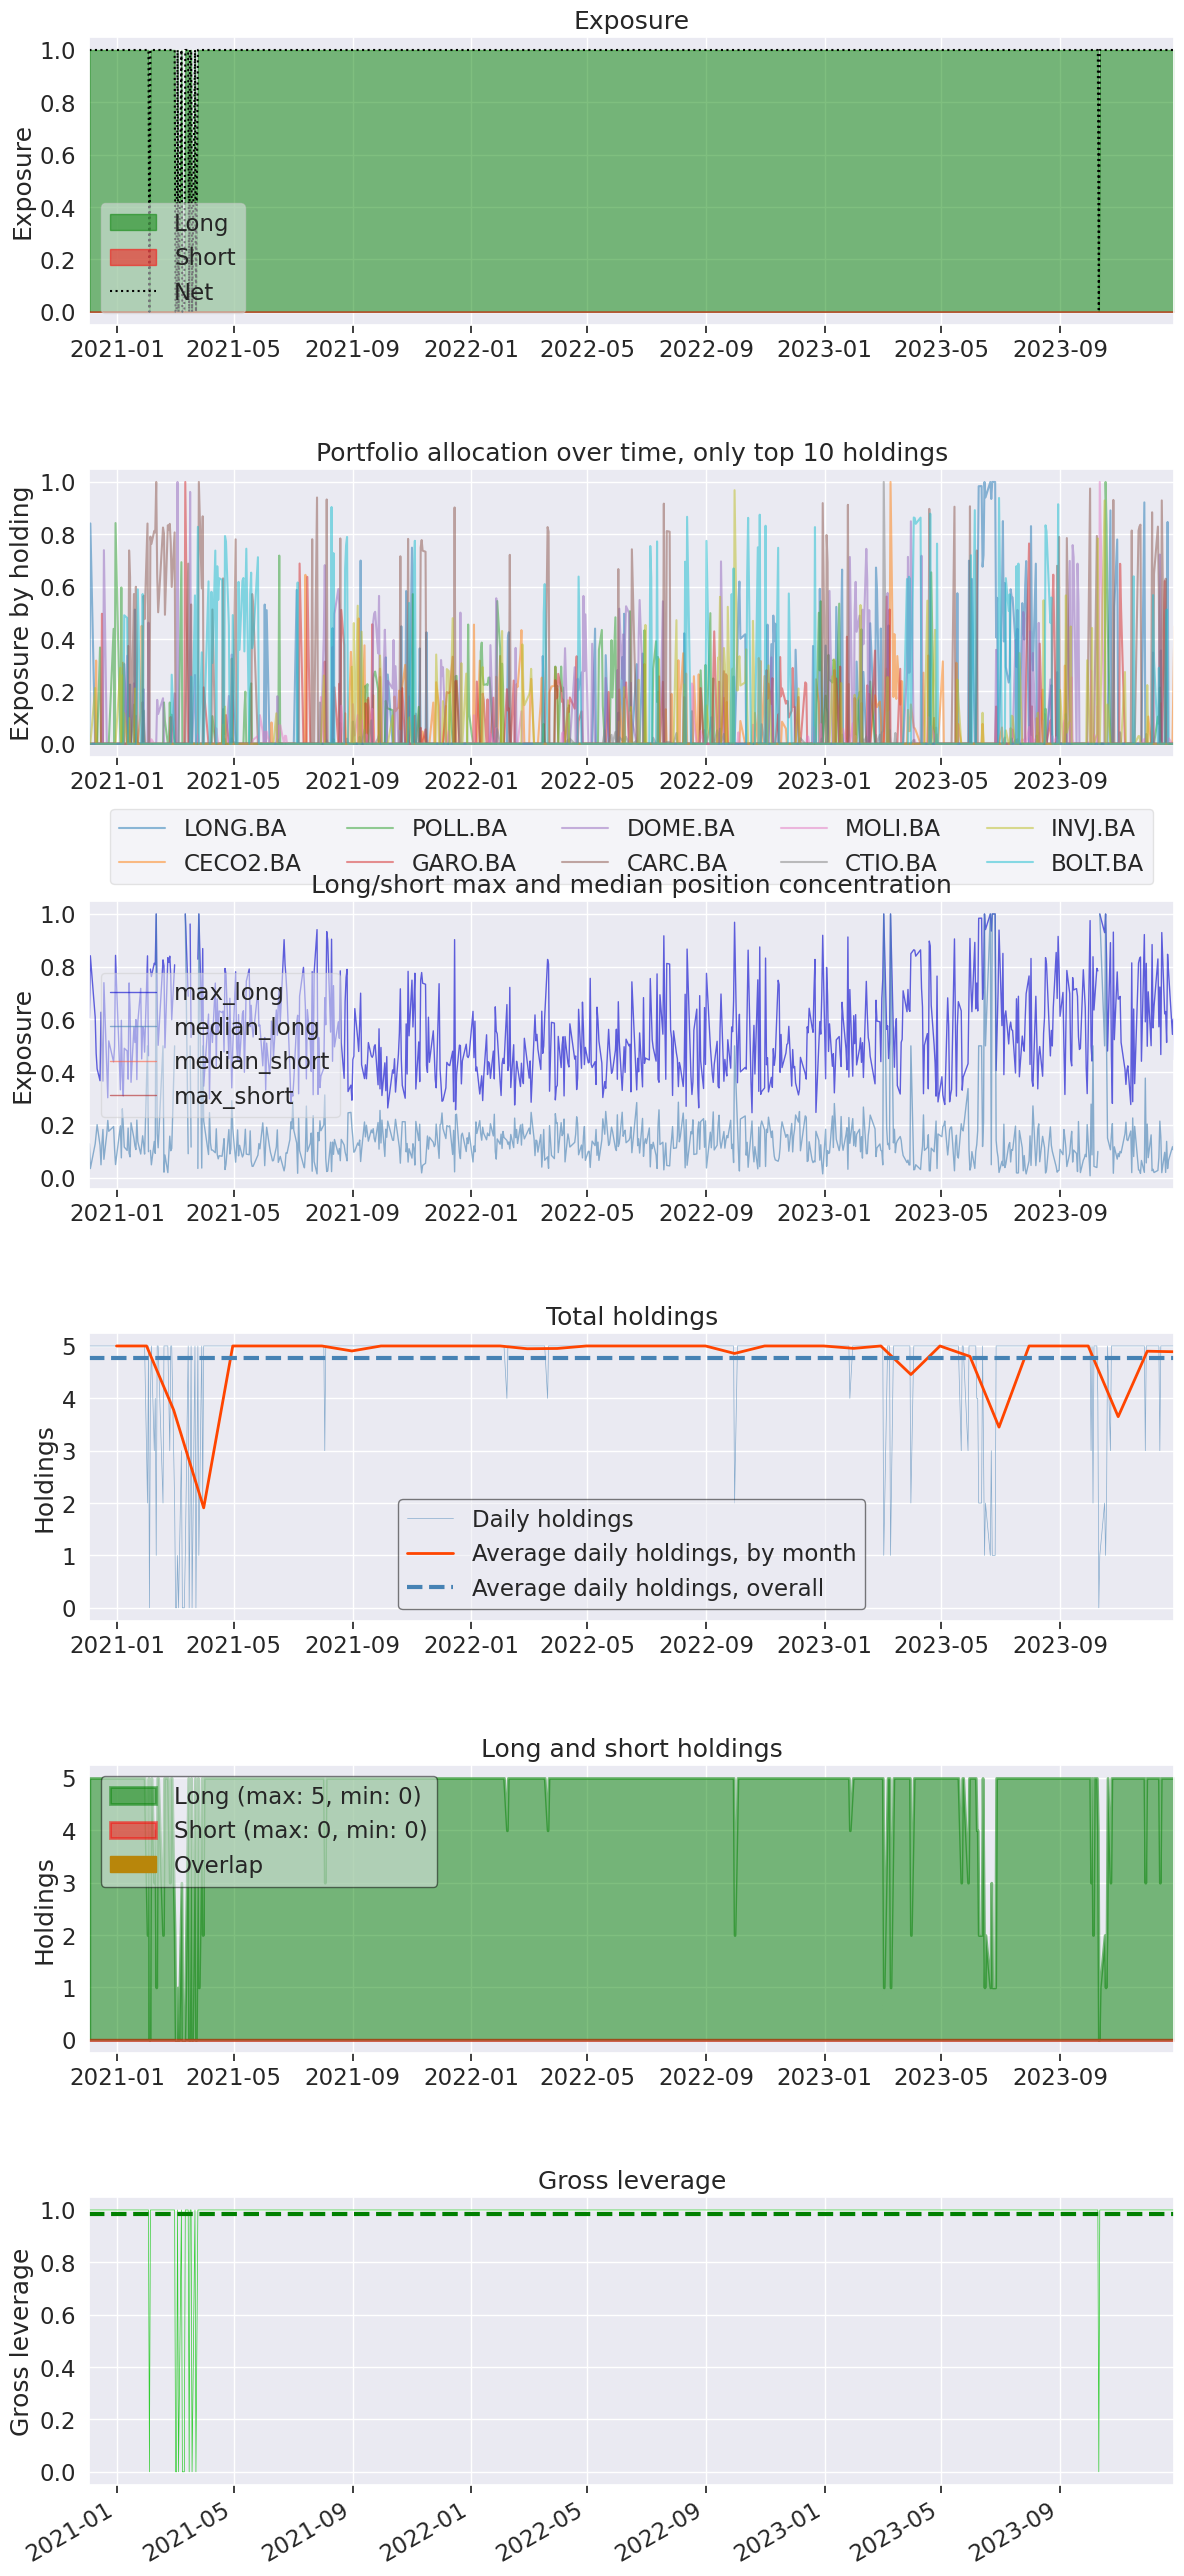

In [ ]:
pf.create_full_tear_sheet(returns, 
                          positions=positions_df, 
                          transactions=None,
                          benchmark_rets=benchmark,
                          live_start_date='2022-01-01', 
                          round_trips=True)